# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
!pip install torchinfo

In [ ]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

In [ ]:
len(train_dataset), len(val_dataset)

(60000, 10000)

Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


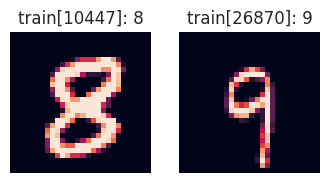

In [ ]:
# берем 2 рандомных индекса
train_idx1, train_idx2 = np.random.randint(0, 60000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx1][0].permute(1, 2, 0))
plt.title(f"train[{train_idx1}]: {classes[train_dataset[train_idx1][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(train_dataset[train_idx2][0].permute(1, 2, 0))
plt.title(f"train[{train_idx2}]: {classes[train_dataset[train_idx2][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Вспомогательные функции

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "black"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [ ]:
simple_cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64*5*5, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn1, input_size=(1, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─MaxPool2d: 1-2                         [1, 28, 13, 13]           --
├─ReLU: 1-3                              [1, 28, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           16,192
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 428,898
Trainable params: 428,898
Non-trainable params: 0
Total mult-adds (M): 2.56
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
simple_cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=10),
).to(device)

summary(simple_cnn2, input_size=(1, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 28, 28]           728
├─ReLU: 1-2                              [1, 28, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 28, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           44,864
├─ReLU: 1-5                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 256]                  803,072
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 851,234
Trainable params: 851,234
Non-trainable params: 0
Total mult-adds (M): 10.17
Input size (MB): 0.00
Forward/backward pass

In [ ]:
simple_cnn3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64*5*5, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=10),
).to(device)

summary(simple_cnn3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─MaxPool2d: 1-2                         [1, 28, 13, 13]           --
├─ReLU: 1-3                              [1, 28, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           16,192
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 128]                  204,928
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 32]                   4,128
├─ReLU: 1-11                             [1, 32]                   --
├─Linear: 1-12                           [1, 10]                   330
T

In [ ]:
simple_cnn4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
).to(device)

summary(simple_cnn4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 28, 28]           728
├─ReLU: 1-2                              [1, 28, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 28, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           44,864
├─ReLU: 1-5                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 128]                  401,536
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 64]                   8,256
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]                   650
T

In [ ]:
simple_cnn5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Flatten(),
    nn.Linear(in_features=64*2*2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

summary(simple_cnn5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─ReLU: 1-2                              [1, 28, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 28, 8, 8]             --
├─Conv2d: 1-4                            [1, 64, 6, 6]             16,192
├─ReLU: 1-5                              [1, 64, 6, 6]             --
├─MaxPool2d: 1-6                         [1, 64, 2, 2]             --
├─Flatten: 1-7                           [1, 256]                  --
├─Linear: 1-8                            [1, 128]                  32,896
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 50,658
Trainable params: 50,658
Non-trainable params: 0
Total mult-adds (M): 0.81
Input size (MB): 0.00
Forward/backward pass siz

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn1.parameters(), lr=0.01)

In [ ]:
history_cnn1 = train(
    simple_cnn1,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn1.state_dict(), "simple_cnn1.pth")

Epoch 40 of 40 took 9.552 s
  training loss: 	0.032458
  validation loss: 	0.170250
  training accuracy: 			99.39 %
  validation accuracy: 			98.14 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn2.parameters(), lr=0.01)
history_cnn2 = train(
    simple_cnn2,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn2.state_dict(), "simple_cnn2.pth")

Epoch 40 of 40 took 9.707 s
  training loss: 	0.082175
  validation loss: 	0.163090
  training accuracy: 			98.79 %
  validation accuracy: 			98.08 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn3.parameters(), lr=0.01)
history_cnn3 = train(
    simple_cnn3,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn3.state_dict(), "simple_cnn3.pth")

Epoch 40 of 40 took 9.721 s
  training loss: 	0.069566
  validation loss: 	0.133606
  training accuracy: 			98.62 %
  validation accuracy: 			98.19 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn4.parameters(), lr=0.01)
history_cnn4 = train(
    simple_cnn4,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn4.state_dict(), "simple_cnn4.pth")

Epoch 40 of 40 took 10.024 s
  training loss: 	0.104683
  validation loss: 	0.218892
  training accuracy: 			98.02 %
  validation accuracy: 			98.14 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn5.parameters(), lr=0.01)
history_cnn5 = train(
    simple_cnn5,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn5.state_dict(), "simple_cnn5.pth")

Epoch 40 of 40 took 9.695 s
  training loss: 	0.046587
  validation loss: 	0.136451
  training accuracy: 			99.02 %
  validation accuracy: 			98.24 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

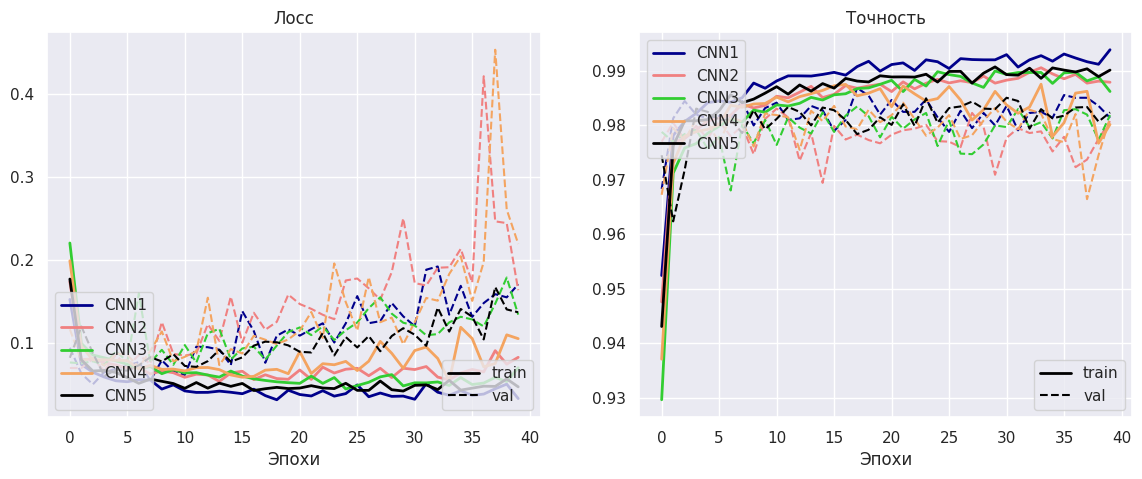

In [ ]:
plot_histories([history_cnn1, history_cnn2, history_cnn3, history_cnn4, history_cnn5], ["CNN1", "CNN2", "CNN3", "CNN4", "CNN5"])

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** Судя по времени обучения, количество слоев либо никак не влияет, либо влияет очень слабо (порядка 3% времени за эпоху) но это можно отнести к погрешности. Что касается качества обучения: 1 и 3 нейросети, отличаются только линейными слоями, что практически не приводут к улучшению accuracy, но зато ошибка имеет не такой угловатый график. Нейросети 2 и 4 тоже отличаются линейными слоями, accuracy у них почит идентично, так же по лоссу можно увидеть, что обе нейросети переобучились. Тоесть в нашем эксперименте количество линейных слоев не така не отразилось на качестве модели. Самой лучшей из всех моделей оказалась модель с двумя сверточными слоями и пуллингом 3х3, не видно четкого переобучения и accuracy самое высокое

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [ ]:
simple_cnn5_3_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

summary(simple_cnn5_3_5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─ReLU: 1-2                              [1, 28, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 28, 8, 8]             --
├─Conv2d: 1-4                            [1, 64, 4, 4]             44,864
├─ReLU: 1-5                              [1, 64, 4, 4]             --
├─MaxPool2d: 1-6                         [1, 64, 1, 1]             --
├─Flatten: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 128]                  8,320
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 54,754
Trainable params: 54,754
Non-trainable params: 0
Total mult-adds (M): 0.92
Input size (MB): 0.00
Forward/backward pass size

In [ ]:
simple_cnn5_5_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Flatten(),
    nn.Linear(in_features=64*2*2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

summary(simple_cnn5_5_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 24, 24]           728
├─ReLU: 1-2                              [1, 28, 24, 24]           --
├─MaxPool2d: 1-3                         [1, 28, 8, 8]             --
├─Conv2d: 1-4                            [1, 64, 6, 6]             16,192
├─ReLU: 1-5                              [1, 64, 6, 6]             --
├─MaxPool2d: 1-6                         [1, 64, 2, 2]             --
├─Flatten: 1-7                           [1, 256]                  --
├─Linear: 1-8                            [1, 128]                  32,896
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 51,106
Trainable params: 51,106
Non-trainable params: 0
Total mult-adds (M): 1.04
Input size (MB): 0.00
Forward/backward pass siz

In [ ]:
simple_cnn5_5_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

summary(simple_cnn5_5_5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 24, 24]           728
├─ReLU: 1-2                              [1, 28, 24, 24]           --
├─MaxPool2d: 1-3                         [1, 28, 8, 8]             --
├─Conv2d: 1-4                            [1, 64, 4, 4]             44,864
├─ReLU: 1-5                              [1, 64, 4, 4]             --
├─MaxPool2d: 1-6                         [1, 64, 1, 1]             --
├─Flatten: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 128]                  8,320
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 55,202
Trainable params: 55,202
Non-trainable params: 0
Total mult-adds (M): 1.15
Input size (MB): 0.00
Forward/backward pass size

In [ ]:
simple_cnn5_3_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Flatten(),
    nn.Linear(in_features=64*2*2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

summary(simple_cnn5_3_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─ReLU: 1-2                              [1, 28, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 28, 8, 8]             --
├─Conv2d: 1-4                            [1, 64, 7, 7]             7,232
├─ReLU: 1-5                              [1, 64, 7, 7]             --
├─MaxPool2d: 1-6                         [1, 64, 2, 2]             --
├─Flatten: 1-7                           [1, 256]                  --
├─Linear: 1-8                            [1, 128]                  32,896
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 41,698
Trainable params: 41,698
Non-trainable params: 0
Total mult-adds (M): 0.58
Input size (MB): 0.00
Forward/backward pass size

In [ ]:
optimizer = torch.optim.Adam(simple_cnn5_3_5.parameters(), lr=0.01)
history_cnn5_3_5 = train(
    simple_cnn5_3_5,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn5_3_5.state_dict(), "simple_cnn5_3_5.pth")

Epoch 40 of 40 took 9.818 s
  training loss: 	0.053891
  validation loss: 	0.164976
  training accuracy: 			98.95 %
  validation accuracy: 			98.24 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn5_5_5.parameters(), lr=0.01)
history_cnn5_5_5 = train(
    simple_cnn5_5_5,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn5_5_5.state_dict(), "simple_cnn5_5_5.pth")

Epoch 40 of 40 took 9.178 s
  training loss: 	0.056047
  validation loss: 	0.258041
  training accuracy: 			99.00 %
  validation accuracy: 			97.50 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn5_5_3.parameters(), lr=0.01)
history_cnn5_5_3 = train(
    simple_cnn5_5_3,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn5_5_3.state_dict(), "simple_cnn5_5_3.pth")

Epoch 40 of 40 took 9.518 s
  training loss: 	0.062541
  validation loss: 	0.159717
  training accuracy: 			98.79 %
  validation accuracy: 			97.82 %


In [ ]:
optimizer = torch.optim.Adam(simple_cnn5_3_2.parameters(), lr=0.01)
history_cnn5_3_2 = train(
    simple_cnn5_3_2,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn5_3_2.state_dict(), "simple_cnn5_3_2.pth")

Epoch 40 of 40 took 9.535 s
  training loss: 	0.076242
  validation loss: 	0.114861
  training accuracy: 			98.02 %
  validation accuracy: 			97.47 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

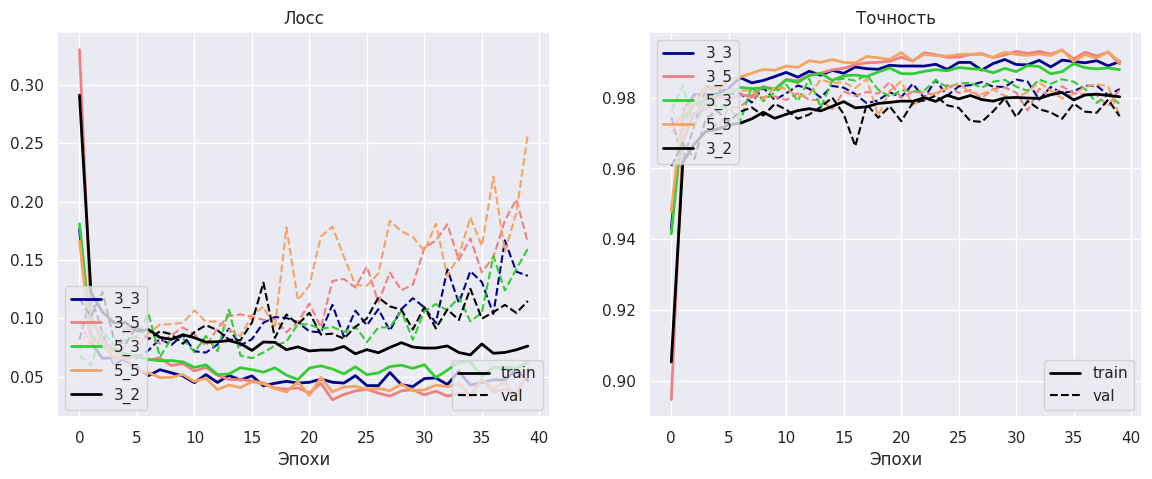

In [ ]:
plot_histories([history_cnn5, history_cnn5_3_5, history_cnn5_5_3, history_cnn5_5_5, history_cnn5_3_2], ["3_3", "3_5", "5_3", "5_5", "3_2"])

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** Размеры ядер влияют так же, как и количество слоев, тоесть никак. Самой лучшей из всех нейросетей оказалась самамя первая с двумя свертками размером 3х3. Все остальные давали качество хуже или переобучались, или и то и то

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

Самлй лучшей оказалась нейросеть с двумя светрочными слоями со свертками размером 3х3 и с пуллингами 3х3. А так же двумя линейными слоями

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [ ]:
incorrect = list([] for i in range(10))

# Function to test what classes performed well
def testClassess():
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        count = 0
        for X_batch, y_batch in val_batch_gen:
             outputs = simple_cnn5(X_batch.to(device))
             _, predicted = torch.max(outputs, 1)
             predicted = predicted.cpu().numpy()
             y_batch = y_batch.cpu().numpy()
             c = (predicted == y_batch)
             for i in range(len(predicted)):
                 label = y_batch[i]
                 class_correct[label] += c[i]
                 if c[i] == False:
                    incorrect[label].append([X_batch[i], predicted[i]])
                 class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
testClassess()

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 96 %
Accuracy of     5 : 97 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %


Неправильные предсказания

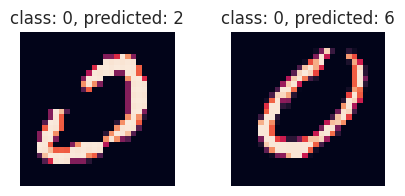

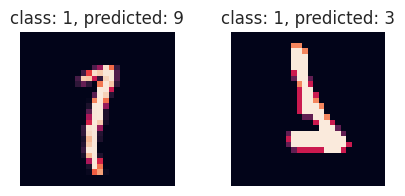

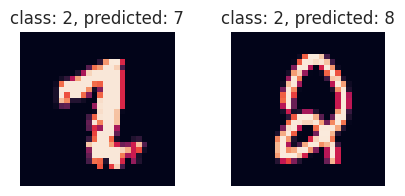

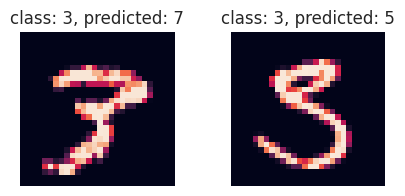

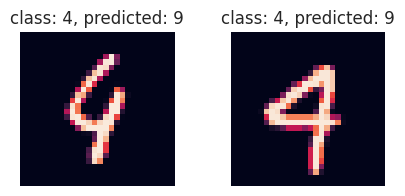

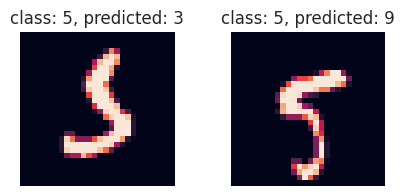

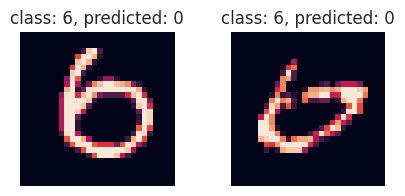

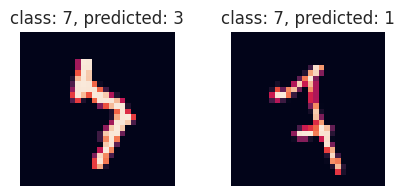

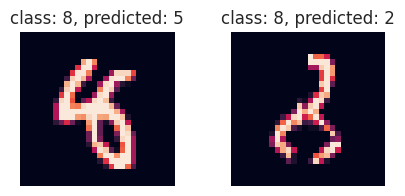

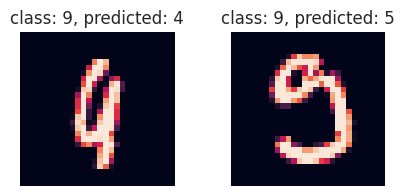

In [ ]:
for i in range(10):
    for j in range(1):
        plt.figure(figsize=(5, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(incorrect[i][j][0].permute(1, 2, 0))
        plt.title(f"class: {i}, predicted: {incorrect[i][j][1]}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(incorrect[i][j+1][0].permute(1, 2, 0))
        plt.title(f"class: {i}, predicted: {incorrect[i][j+1][1]}")
        plt.axis("off");

**Ответ:** Нет, результат точности предсказаний по классам не равномерный. Возможно это происходит из за того, что некоторые цифры люди могут писать хуже, чем другие цифры, из за чего возникают ситуации непонятного написания цифр, всявязи с чем нейросеть не может правильно предсказать класс. Это хорошо видно по цифрам, класс которых предсказан неверно, я бы и сам не все правильно отличил

**Вывод по всей задаче:** С помощью даже довольно небольшой и простой сверточной нейронной сети можно добиться очень высокого качества предсказания (прада датасет довольно простой, но это не так важно). Причем основной проблемой в неточности предсказаний будет не только плохая предсказательная способность нейросети, но и непонятная фотография. Это можно сравнить с выбросом и прямой, если в облаке точек есть выброс, то прямая не должна его предсказывать, так и с плохонаписанными цифрами.

---
### Задача 2. Перенос стиля

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

In [7]:
!unzip data.zip -d

error:  must specify directory to which to extract with -d option


Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

Напишем функцию для запуска метода для заданной картинки контента и стиля, а также функцию визуализации результатов.

In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [ ]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [12]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

result_paths = []
count = 0
for content_image, style_image in zip(content_images, style_images):
    if count == 0:
        count += 1
        continue
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

контент1.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=189469442048.0000, content_loss=      0.0000, style loss=189454530000.0000, tv loss=14906578.0000


KeyboardInterrupt: 

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

**Вывод:**
<...>